In [11]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# plotting-- for future use
plt.style.use('default')
sns.set_palette("husl")

# loading
df = pd.read_parquet('../data/processed/cleaned_citibike_data_with_features.parquet')

# check for correct load
print(f"Data shape: {df.shape}")
#print(df.head(5))

Data shape: (3209060, 17)


In [28]:
# USAGE EXAMPLE:
print("""
USAGE:
1. Run the analysis: df_clean, outliers = outlier_impact_analysis(df)
2. Review the statistical impact and visualizations
3. Make your decision based on the recommendation
4. If removing outliers: df_final = create_outlier_removal_function(df, method='iqr')

METHODS AVAILABLE:
- 'iqr': InterQuartile Range method (most common)
- 'zscore': Z-score method 
- 'business': Business logic (1 min to 2 hours)
""")


USAGE:
1. Run the analysis: df_clean, outliers = outlier_impact_analysis(df)
2. Review the statistical impact and visualizations
3. Make your decision based on the recommendation
4. If removing outliers: df_final = create_outlier_removal_function(df, method='iqr')

METHODS AVAILABLE:
- 'iqr': InterQuartile Range method (most common)
- 'zscore': Z-score method 
- 'business': Business logic (1 min to 2 hours)



In [23]:
def outlier_impact_analysis(df, duration_col='duration_minutes'):
    """
    Comprehensive analysis to determine the impact of outliers on your bike sharing data
    and help make a data-driven decision about outlier removal
    """
    
    print("=" * 60)
    print("OUTLIER IMPACT ANALYSIS FOR DECISION MAKING")
    print("=" * 60)
    
    # 1. IDENTIFY OUTLIERS USING MULTIPLE METHODS
    print("\n1. OUTLIER IDENTIFICATION")
    print("-" * 30)
    
    # Method 1: IQR Method
    Q1 = df[duration_col].quantile(0.25)
    Q3 = df[duration_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    iqr_outliers = df[(df[duration_col] < lower_bound) | (df[duration_col] > upper_bound)]
    
    # Method 2: Z-Score Method (typically |z| > 3)
    z_scores = np.abs(stats.zscore(df[duration_col]))
    zscore_outliers = df[z_scores > 3]
    
    # Method 3: Modified Z-Score (using median)
    median = df[duration_col].median()
    mad = np.median(np.abs(df[duration_col] - median))
    modified_z_scores = 0.6745 * (df[duration_col] - median) / mad
    modified_zscore_outliers = df[np.abs(modified_z_scores) > 3.5]
    
    print(f"Total records: {len(df):,}")
    print(f"IQR outliers (±1.5*IQR): {len(iqr_outliers):,} ({len(iqr_outliers)/len(df)*100:.2f}%)")
    print(f"Z-score outliers (|z|>3): {len(zscore_outliers):,} ({len(zscore_outliers)/len(df)*100:.2f}%)")
    print(f"Modified Z-score outliers: {len(modified_zscore_outliers):,} ({len(modified_zscore_outliers)/len(df)*100:.2f}%)")
    print(f"IQR bounds: {lower_bound:.2f} to {upper_bound:.2f} minutes")
    
    # 2. BUSINESS LOGIC ASSESSMENT
    print("\n2. BUSINESS LOGIC ASSESSMENT")
    print("-" * 30)
    
    # Analyze extreme values
    extreme_long = df[df[duration_col] > 120]  # rides > 2 hours
    extreme_short = df[df[duration_col] < 1]   # rides < 1 minute
    
    print(f"Rides > 2 hours: {len(extreme_long):,} ({len(extreme_long)/len(df)*100:.2f}%)")
    print(f"Rides < 1 minute: {len(extreme_short):,} ({len(extreme_short)/len(df)*100:.2f}%)")
    print(f"Maximum duration: {df[duration_col].max():.2f} minutes ({df[duration_col].max()/60:.1f} hours)")
    print(f"Minimum duration: {df[duration_col].min():.2f} minutes")
    
    # 3. COMPARE DATASETS WITH AND WITHOUT OUTLIERS
    print("\n3. STATISTICAL IMPACT COMPARISON")
    print("-" * 30)
    
    # Create cleaned dataset using IQR method (most common)
    df_clean = df[(df[duration_col] >= lower_bound) & (df[duration_col] <= upper_bound)]
    
    # Compare basic statistics
    original_stats = df[duration_col].describe()
    clean_stats = df_clean[duration_col].describe()
    
    print("DESCRIPTIVE STATISTICS COMPARISON:")
    print(f"{'Statistic':<12} {'Original':<12} {'Clean':<12} {'Change':<12}")
    print("-" * 50)
    
    for stat in ['mean', 'std', 'min', '25%', '50%', '75%', 'max']:
        orig_val = original_stats[stat]
        clean_val = clean_stats[stat]
        change = ((clean_val - orig_val) / orig_val * 100) if orig_val != 0 else 0
        print(f"{stat:<12} {orig_val:<12.2f} {clean_val:<12.2f} {change:<12.2f}%")
    
    # 4. IMPACT ON KEY RELATIONSHIPS
    print("\n4. IMPACT ON KEY RELATIONSHIPS")
    print("-" * 30)
    
    # Compare correlations
    numeric_cols = ['hour', duration_col]
    if len(numeric_cols) > 1:
        orig_corr = df[numeric_cols].corr().iloc[0, 1]
        clean_corr = df_clean[numeric_cols].corr().iloc[0, 1]
        print(f"Hour-Duration correlation:")
        print(f"  Original: {orig_corr:.4f}")
        print(f"  Clean: {clean_corr:.4f}")
        print(f"  Change: {(clean_corr - orig_corr):.4f}")
    
    # Compare group means
    print(f"\nMean duration by rideable type:")
    orig_means = df.groupby('rideable_type')[duration_col].mean()
    clean_means = df_clean.groupby('rideable_type')[duration_col].mean()
    
    for rideable_type in orig_means.index:
        orig_mean = orig_means[rideable_type]
        clean_mean = clean_means[rideable_type] if rideable_type in clean_means.index else np.nan
        change = ((clean_mean - orig_mean) / orig_mean * 100) if not np.isnan(clean_mean) and orig_mean != 0 else np.nan
        print(f"  {rideable_type}: {orig_mean:.2f} → {clean_mean:.2f} ({change:.1f}% change)")
    
    # 5. STATISTICAL TEST COMPARISONS
    print("\n5. STATISTICAL TEST COMPARISONS")
    print("-" * 30)
    
    # ANOVA: Duration by rideable type
    def perform_anova(data, group_col, value_col):
        groups = [group[value_col].values for name, group in data.groupby(group_col)]
        f_stat, p_val = stats.f_oneway(*groups)
        return f_stat, p_val
    
    orig_f, orig_p = perform_anova(df, 'rideable_type', duration_col)
    clean_f, clean_p = perform_anova(df_clean, 'rideable_type', duration_col)
    
    print(f"ANOVA (Duration by Rideable Type):")
    print(f"  Original: F={orig_f:.2f}, p={orig_p:.4f}")
    print(f"  Clean: F={clean_f:.2f}, p={clean_p:.4f}")
    print(f"  Significance change: {('Yes' if (orig_p < 0.05) != (clean_p < 0.05) else 'No')}")
    
    # 6. VISUALIZATION OF IMPACT
    create_outlier_impact_visualizations(df, df_clean, duration_col, lower_bound, upper_bound)
    
    # 7. DECISION FRAMEWORK
    print("\n6. DECISION FRAMEWORK")
    print("-" * 30)
    
    # Calculate impact scores
    mean_change = abs((clean_stats['mean'] - original_stats['mean']) / original_stats['mean'] * 100)
    std_change = abs((clean_stats['std'] - original_stats['std']) / original_stats['std'] * 100)
    data_loss = len(iqr_outliers) / len(df) * 100
    
    print(f"Impact Assessment:")
    print(f"  Mean change: {mean_change:.2f}%")
    print(f"  Std deviation change: {std_change:.2f}%")
    print(f"  Data loss: {data_loss:.2f}%")
    
    # Decision criteria
    print(f"\nDecision Criteria:")
    print(f"  ✓ Low data loss (<5%): {'Yes' if data_loss < 5 else 'No'}")
    print(f"  ✓ High mean change (>10%): {'Yes' if mean_change > 10 else 'No'}")
    print(f"  ✓ High std change (>20%): {'Yes' if std_change > 20 else 'No'}")
    
    # Recommendation
    print(f"\n7. RECOMMENDATION")
    print("-" * 30)
    
    if data_loss > 10:
        recommendation = "KEEP OUTLIERS - Too much data loss"
    elif mean_change > 15 and std_change > 25:
        recommendation = "REMOVE OUTLIERS - Significant impact on distribution"
    elif mean_change < 5 and std_change < 10:
        recommendation = "EITHER - Minimal impact"
    else:
        recommendation = "CONDITIONAL - Consider your analysis goals"
    
    print(f"RECOMMENDATION: {recommendation}")
    
    if "CONDITIONAL" in recommendation:
        print("\nConsiderations:")
        print("- For predictive modeling: Consider keeping outliers if they represent real scenarios")
        print("- For descriptive analysis: Remove if outliers distort typical patterns")
        print("- For hypothesis testing: Remove if they violate test assumptions")
    
    return df_clean

OUTLIER IMPACT ANALYSIS FOR DECISION MAKING

1. OUTLIER IDENTIFICATION
------------------------------
Total records: 3,209,060
IQR outliers (±1.5*IQR): 199,623 (6.22%)
Z-score outliers (|z|>3): 21,028 (0.66%)
Modified Z-score outliers: 181,662 (5.66%)
IQR bounds: -10.66 to 31.55 minutes

2. BUSINESS LOGIC ASSESSMENT
------------------------------
Rides > 2 hours: 7,416 (0.23%)
Rides < 1 minute: 0 (0.00%)
Maximum duration: 1494.62 minutes (24.9 hours)
Minimum duration: 1.00 minutes

3. STATISTICAL IMPACT COMPARISON
------------------------------
DESCRIPTIVE STATISTICS COMPARISON:
Statistic    Original     Clean        Change      
--------------------------------------------------
mean         13.01        10.26        -21.13      %
std          20.72        6.88         -66.79      %
min          1.00         1.00         0.00        %
25%          5.17         4.96         -3.96       %
50%          8.97         8.41         -6.27       %
75%          15.72        13.98        -11.06 

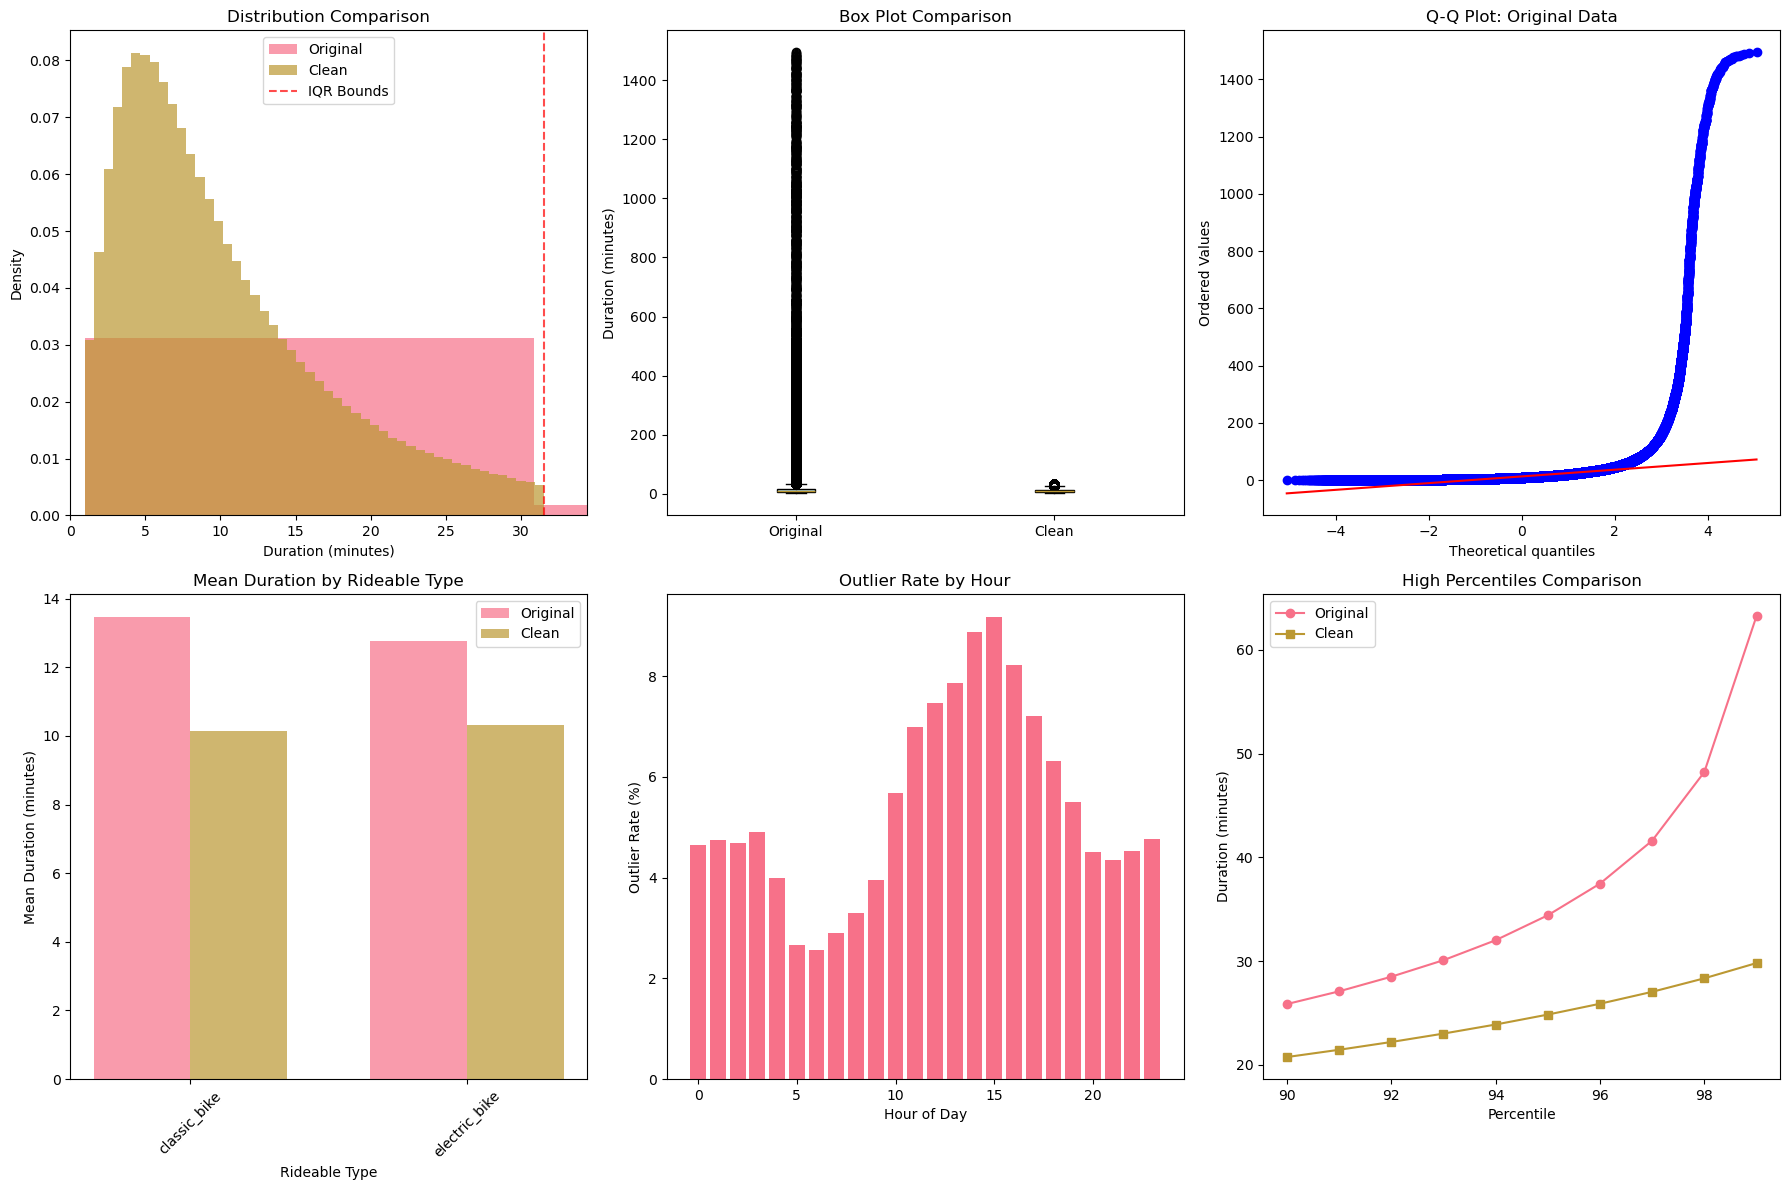


6. DECISION FRAMEWORK
------------------------------
Impact Assessment:
  Mean change: 21.13%
  Std deviation change: 66.79%
  Data loss: 6.22%

Decision Criteria:
  ✓ Low data loss (<5%): No
  ✓ High mean change (>10%): Yes
  ✓ High std change (>20%): Yes

7. RECOMMENDATION
------------------------------
RECOMMENDATION: REMOVE OUTLIERS - Significant impact on distribution


In [29]:
df_clean = outlier_impact_analysis(df, duration_col='duration_minutes')

In [ ]:
def create_outlier_removal_function(df, duration_col='duration_minutes', method='iqr'):
    """
    Create a function to remove outliers based on your decision
    """
    if method == 'iqr':
        Q1 = df[duration_col].quantile(0.25)
        Q3 = df[duration_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[duration_col] >= lower_bound) & (df[duration_col] <= upper_bound)]
    
    elif method == 'zscore':
        z_scores = np.abs(stats.zscore(df[duration_col]))
        return df[z_scores <= 3]
    
    elif method == 'business':
        # Business logic: rides between 1 minute and 2 hours
        return df[(df[duration_col] >= 1) & (df[duration_col] <= 120)]
    
    else:
        return df



In [30]:
# USAGE EXAMPLE AND INSTRUCTIONS
print("""
USAGE INSTRUCTIONS:

# Step 1: Run conservative cleaning
df_clean, quality_issues = conservative_data_quality_check(df)

# Step 2: Visualize the impact
visualize_conservative_cleaning(df, df_clean, quality_issues)

# Step 3: Review future strategy
create_seasonal_outlier_strategy(df)
create_business_rules_framework()

# Step 4: Use cleaned data for current analysis
# Your analysis functions will now work with df_clean, which preserves
# seasonal patterns while removing obvious data quality issues

PHILOSOPHY:
- Remove only obvious data quality errors
- Preserve potential seasonal variations
- Minimize data loss for future comprehensive analysis
- Focus on patterns rather than individual outliers
""")


USAGE INSTRUCTIONS:

# Step 1: Run conservative cleaning
df_clean, quality_issues = conservative_data_quality_check(df)

# Step 2: Visualize the impact
visualize_conservative_cleaning(df, df_clean, quality_issues)

# Step 3: Review future strategy
create_seasonal_outlier_strategy(df)
create_business_rules_framework()

# Step 4: Use cleaned data for current analysis
# Your analysis functions will now work with df_clean, which preserves
# seasonal patterns while removing obvious data quality issues

PHILOSOPHY:
- Remove only obvious data quality errors
- Preserve potential seasonal variations
- Minimize data loss for future comprehensive analysis
- Focus on patterns rather than individual outliers



In [31]:
def conservative_data_quality_check(df, duration_col='duration_minutes'):
    """
    Conservative approach focusing only on obvious data quality issues
    while preserving legitimate seasonal variations
    """
    
    print("=" * 70)
    print("CONSERVATIVE DATA QUALITY APPROACH")
    print("Preserving Seasonal Patterns - Removing Only Obvious Errors")
    print("=" * 70)
    
    # 1. IDENTIFY OBVIOUS DATA QUALITY ISSUES
    print("\n1. OBVIOUS DATA QUALITY ISSUES")
    print("-" * 40)
    
    original_count = len(df)
    
    # Issue 1: Impossible durations (negative or zero)
    impossible_durations = df[df[duration_col] <= 0]
    
    # Issue 2: Extremely short rides (likely system errors - under 30 seconds)
    extremely_short = df[(df[duration_col] > 0) & (df[duration_col] < 0.5)]
    
    # Issue 3: Impossibly long rides (likely forgot to dock - over 24 hours)
    impossibly_long = df[df[duration_col] > 1440]  # 24 hours
    
    # Issue 4: Same start/end location with very long duration (likely system error)
    if 'start_lat' in df.columns and 'end_lat' in df.columns:
        same_location = df[
            (df['start_lat'] == df['end_lat']) & 
            (df['start_lng'] == df['end_lng']) & 
            (df[duration_col] > 120)  # 2+ hours at same spot
        ]
    else:
        same_location = pd.DataFrame()  # Empty if location data not available
    
    print(f"Original records: {original_count:,}")
    print(f"Impossible durations (≤0): {len(impossible_durations):,} ({len(impossible_durations)/original_count*100:.3f}%)")
    print(f"Extremely short (<30 sec): {len(extremely_short):,} ({len(extremely_short)/original_count*100:.3f}%)")
    print(f"Impossibly long (>24 hrs): {len(impossibly_long):,} ({len(impossibly_long)/original_count*100:.3f}%)")
    if len(same_location) > 0:
        print(f"Same location, long duration: {len(same_location):,} ({len(same_location)/original_count*100:.3f}%)")
    
    # 2. SEASONAL OUTLIER PRESERVATION
    print("\n2. SEASONAL PATTERN PRESERVATION")
    print("-" * 40)
    
    # Calculate percentiles that we'll preserve (much more conservative)
    p99_9 = df[duration_col].quantile(0.999)  # Keep 99.9% of data
    p0_1 = df[duration_col].quantile(0.001)
    
    # Statistical outliers we're NOT removing (preserving for seasonal analysis)
    statistical_outliers = df[
        (df[duration_col] > df[duration_col].quantile(0.75) + 1.5 * 
         (df[duration_col].quantile(0.75) - df[duration_col].quantile(0.25))) |
        (df[duration_col] < df[duration_col].quantile(0.25) - 1.5 * 
         (df[duration_col].quantile(0.75) - df[duration_col].quantile(0.25)))
    ]
    
    print(f"99.9th percentile duration: {p99_9:.1f} minutes ({p99_9/60:.1f} hours)")
    print(f"0.1st percentile duration: {p0_1:.1f} minutes")
    print(f"Statistical outliers preserved: {len(statistical_outliers):,} ({len(statistical_outliers)/original_count*100:.1f}%)")
    print("→ These may represent legitimate seasonal variations")
    
    # 3. CREATE CLEANED DATASET
    print("\n3. DATA CLEANING RESULTS")
    print("-" * 40)
    
    # Combine all quality issues to remove
    quality_issues = pd.concat([
        impossible_durations,
        extremely_short,
        impossibly_long,
        same_location
    ]).drop_duplicates()
    
    # Create clean dataset
    df_clean = df[~df.index.isin(quality_issues.index)]
    
    records_removed = len(quality_issues)
    records_kept = len(df_clean)
    
    print(f"Records removed (quality issues): {records_removed:,} ({records_removed/original_count*100:.3f}%)")
    print(f"Records kept: {records_kept:,} ({records_kept/original_count*100:.1f}%)")
    print(f"Data preservation rate: {records_kept/original_count*100:.1f}%")
    
    # 4. IMPACT ASSESSMENT
    print("\n4. IMPACT ON ANALYSIS")
    print("-" * 40)
    
    original_mean = df[duration_col].mean()
    clean_mean = df_clean[duration_col].mean()
    mean_change = ((clean_mean - original_mean) / original_mean * 100)
    
    original_std = df[duration_col].std()
    clean_std = df_clean[duration_col].std()
    std_change = ((clean_std - original_std) / original_std * 100)
    
    print(f"Mean duration change: {mean_change:.2f}%")
    print(f"Std deviation change: {std_change:.2f}%")
    print("→ Minimal impact preserves seasonal patterns")
    
    # 5. QUALITY ISSUE BREAKDOWN
    print("\n5. DETAILED QUALITY ISSUE BREAKDOWN")
    print("-" * 40)
    
    if len(impossibly_long) > 0:
        print(f"Longest ride duration: {df[duration_col].max():.1f} minutes ({df[duration_col].max()/60:.1f} hours)")
        print(f"Rides over 12 hours: {len(df[df[duration_col] > 720]):,}")
        print(f"Rides over 6 hours: {len(df[df[duration_col] > 360]):,}")
    
    if len(extremely_short) > 0:
        print(f"Shortest positive ride: {df[df[duration_col] > 0][duration_col].min():.3f} minutes")
    
    return df_clean, quality_issues



In [38]:
df_clean, quality_issues = conservative_data_quality_check(df)

CONSERVATIVE DATA QUALITY APPROACH
Preserving Seasonal Patterns - Removing Only Obvious Errors

1. OBVIOUS DATA QUALITY ISSUES
----------------------------------------
Original records: 3,209,060
Impossible durations (≤0): 0 (0.000%)
Extremely short (<30 sec): 0 (0.000%)
Impossibly long (>24 hrs): 28 (0.001%)
Same location, long duration: 543 (0.017%)

2. SEASONAL PATTERN PRESERVATION
----------------------------------------
99.9th percentile duration: 188.5 minutes (3.1 hours)
0.1st percentile duration: 1.1 minutes
Statistical outliers preserved: 199,623 (6.2%)
→ These may represent legitimate seasonal variations

3. DATA CLEANING RESULTS
----------------------------------------
Records removed (quality issues): 570 (0.018%)
Records kept: 3,208,490 (100.0%)
Data preservation rate: 100.0%

4. IMPACT ON ANALYSIS
----------------------------------------
Mean duration change: -0.43%
Std deviation change: -5.04%
→ Minimal impact preserves seasonal patterns

5. DETAILED QUALITY ISSUE BREAKD

In [33]:
def create_seasonal_outlier_strategy(df, duration_col='duration_minutes'):
    """
    Create a strategy for handling outliers when you have more seasonal data
    """
    
    print("\n" + "=" * 70)
    print("FUTURE SEASONAL OUTLIER STRATEGY")
    print("=" * 70)
    
    print("\nWhen you have 12+ months of data, consider this approach:")
    print("\n1. SEASONAL OUTLIER DETECTION")
    print("   - Calculate separate outlier bounds for each season")
    print("   - Use month-specific or quarter-specific thresholds")
    print("   - Account for weather patterns in your region")
    
    print("\n2. ROLLING OUTLIER BOUNDS")
    print("   - Use 3-month rolling windows for outlier detection")
    print("   - Adjust bounds based on temperature/weather data if available")
    print("   - Consider day-of-week and hour-of-day patterns")
    
    print("\n3. CONTEXTUAL VALIDATION")
    print("   - Long rides in summer: likely legitimate leisure rides")
    print("   - Long rides in winter: may indicate system issues")
    print("   - Short rides during rush hour: likely normal commuting")
    
    print("\n4. BUSINESS LOGIC VALIDATION")
    print("   - Rides > 8 hours: Review manually or set business rules")
    print("   - Rides < 1 minute: Likely system errors regardless of season")
    print("   - Consider bike type differences (e-bikes vs regular)")



In [34]:
create_seasonal_outlier_strategy(df, duration_col='duration_minutes')


FUTURE SEASONAL OUTLIER STRATEGY

When you have 12+ months of data, consider this approach:

1. SEASONAL OUTLIER DETECTION
   - Calculate separate outlier bounds for each season
   - Use month-specific or quarter-specific thresholds
   - Account for weather patterns in your region

2. ROLLING OUTLIER BOUNDS
   - Use 3-month rolling windows for outlier detection
   - Adjust bounds based on temperature/weather data if available
   - Consider day-of-week and hour-of-day patterns

3. CONTEXTUAL VALIDATION
   - Long rides in summer: likely legitimate leisure rides
   - Long rides in winter: may indicate system issues
   - Short rides during rush hour: likely normal commuting

4. BUSINESS LOGIC VALIDATION
   - Rides > 8 hours: Review manually or set business rules
   - Rides < 1 minute: Likely system errors regardless of season
   - Consider bike type differences (e-bikes vs regular)


In [35]:
def visualize_conservative_cleaning(df_original, df_clean, quality_issues, duration_col='duration_minutes'):
    """
    Visualize the impact of conservative cleaning
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Distribution comparison (zoomed to reasonable range)
    ax1 = axes[0, 0]
    max_duration = min(180, df_original[duration_col].quantile(0.99))  # Cap at 3 hours or 99th percentile
    
    ax1.hist(df_original[duration_col], bins=50, alpha=0.7, label='Original', 
             range=(0, max_duration), density=True, color='lightcoral')
    ax1.hist(df_clean[duration_col], bins=50, alpha=0.7, label='Conservative Clean', 
             range=(0, max_duration), density=True, color='lightblue')
    ax1.set_xlabel('Duration (minutes)')
    ax1.set_ylabel('Density')
    ax1.set_title('Distribution: Conservative Cleaning Impact')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Quality issues by type
    ax2 = axes[0, 1]
    issue_types = ['≤0 min', '<0.5 min', '>24 hrs', 'Same location']
    issue_counts = [
        len(df_original[df_original[duration_col] <= 0]),
        len(df_original[(df_original[duration_col] > 0) & (df_original[duration_col] < 0.5)]),
        len(df_original[df_original[duration_col] > 1440]),
        len(quality_issues) - len(df_original[df_original[duration_col] <= 0]) - 
        len(df_original[(df_original[duration_col] > 0) & (df_original[duration_col] < 0.5)]) -
        len(df_original[df_original[duration_col] > 1440])
    ]
    
    colors = ['red', 'orange', 'purple', 'brown']
    ax2.bar(issue_types, issue_counts, color=colors, alpha=0.7)
    ax2.set_ylabel('Number of Records')
    ax2.set_title('Quality Issues Removed')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Preserved "outliers" by hour
    ax3 = axes[1, 0]
    Q1 = df_original[duration_col].quantile(0.25)
    Q3 = df_original[duration_col].quantile(0.75)
    IQR = Q3 - Q1
    statistical_outliers = df_clean[
        (df_clean[duration_col] > Q3 + 1.5 * IQR) | 
        (df_clean[duration_col] < Q1 - 1.5 * IQR)
    ]
    
    if len(statistical_outliers) > 0:
        outlier_by_hour = statistical_outliers.groupby('hour').size()
        total_by_hour = df_clean.groupby('hour').size()
        outlier_rate = (outlier_by_hour / total_by_hour * 100).reindex(range(24), fill_value=0)
        
        ax3.bar(outlier_rate.index, outlier_rate.values, color='green', alpha=0.7)
        ax3.set_xlabel('Hour of Day')
        ax3.set_ylabel('Statistical Outlier Rate (%)')
        ax3.set_title('Preserved Statistical Outliers by Hour')
        ax3.set_xticks(range(0, 24, 2))
    else:
        ax3.text(0.5, 0.5, 'No statistical outliers\nin cleaned data', 
                ha='center', va='center', transform=ax3.transAxes)
        ax3.set_title('Preserved Statistical Outliers by Hour')
    
    # 4. Data preservation summary
    ax4 = axes[1, 1]
    preservation_data = [
        len(df_clean),
        len(quality_issues)
    ]
    labels = [f'Preserved\n{len(df_clean):,}\n({len(df_clean)/len(df_original)*100:.1f}%)',
              f'Removed\n{len(quality_issues):,}\n({len(quality_issues)/len(df_original)*100:.1f}%)']
    colors = ['lightgreen', 'lightcoral']
    
    ax4.pie(preservation_data, labels=labels, colors=colors, autopct='', startangle=90)
    ax4.set_title('Data Preservation Summary')
    
    plt.tight_layout()
    plt.show()



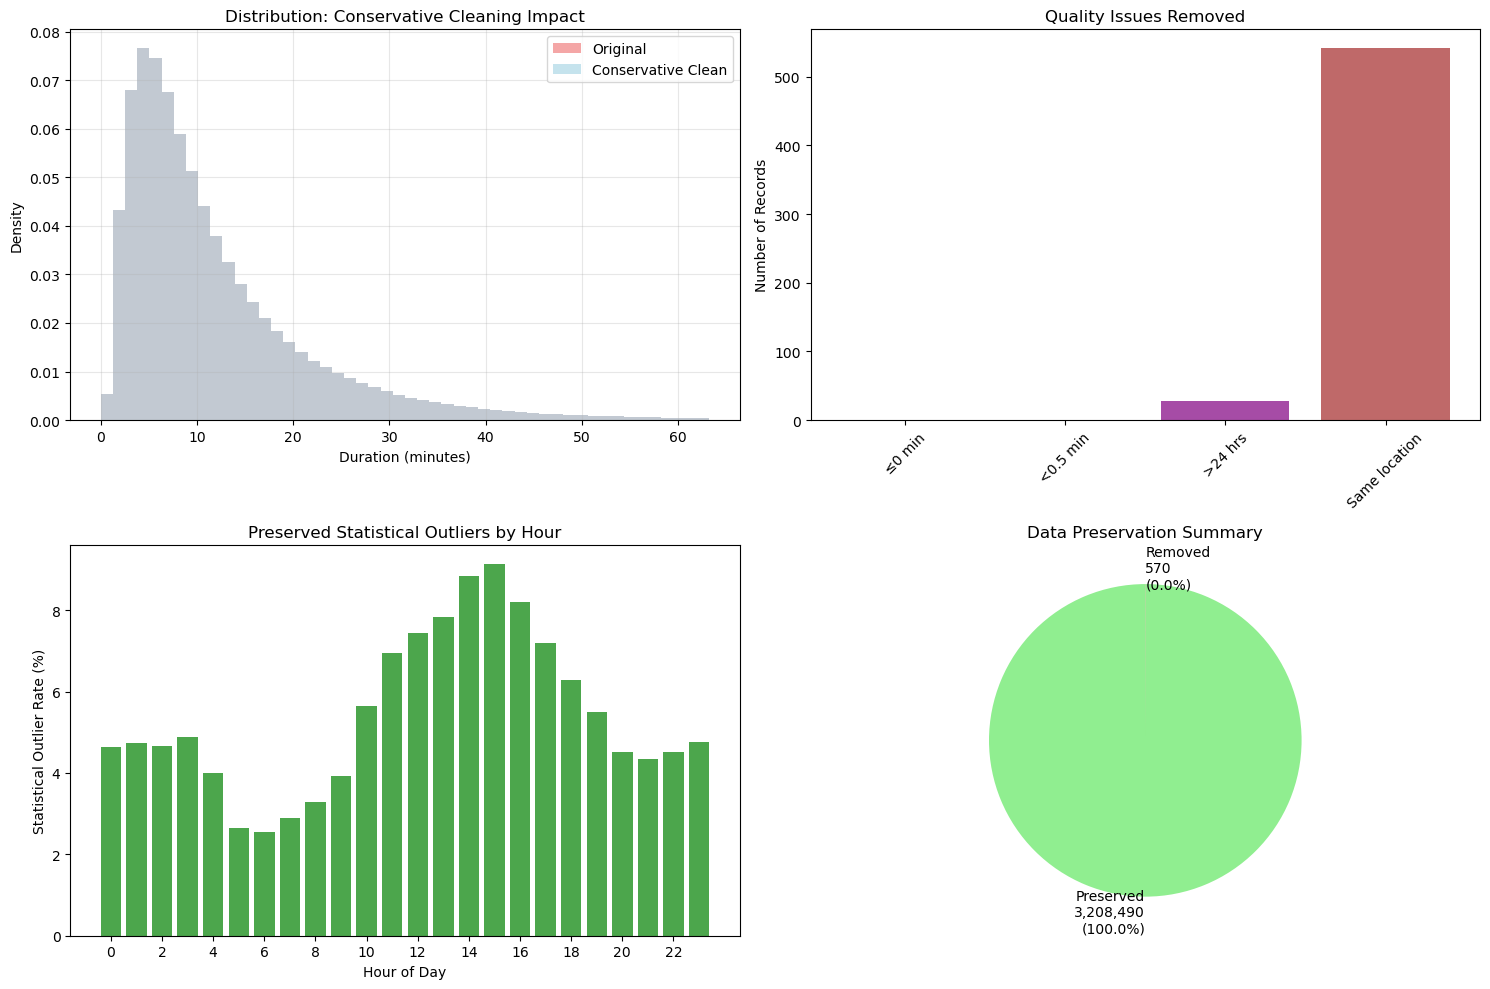

In [39]:
visualize_conservative_cleaning(df, df_clean, quality_issues)

In [ ]:
def create_business_rules_framework():
    """
    Framework for creating business-specific data quality rules
    """
    
    print("\n" + "=" * 70)
    print("BUSINESS RULES FRAMEWORK")
    print("=" * 70)
    
    business_rules = {
        'Critical Issues (Always Remove)': [
            'Duration ≤ 0 minutes',
            'Duration > 24 hours (1440 minutes)',
            'Same start/end location with >2 hour duration',
            'Missing critical fields (start_time, end_time)'
        ],
        
        'Likely Errors (Remove with Caution)': [
            'Duration < 30 seconds',
            'Duration > 8 hours (480 minutes)',
            'Rides starting/ending outside service area',
            'Impossible speed (distance/time > bike speed limits)'
        ],
        
        'Preserve for Seasonal Analysis': [
            'Long leisure rides (2-6 hours) in good weather',
            'Short rides during rush hours',
            'Weekend vs weekday pattern variations',
            'Holiday and event-related usage spikes'
        ]
    }
    
    for category, rules in business_rules.items():
        print(f"\n{category}:")
        for rule in rules:
            print(f"  • {rule}")
    
    print(f"\nRECOMMENDED APPROACH:")
    print(f"1. Apply only 'Critical Issues' rules to current single-month data")
    print(f"2. Flag 'Likely Errors' for review when you have seasonal context")
    print(f"3. Preserve all other data for comprehensive seasonal analysis")

